**Get harp TTL data frame**

In [1]:
# Import main libraries and define data folder
import harp
import pandas as pd
from harp.model import Model, Register, Access
import os
from pathlib import Path
import matplotlib.pyplot as plt

import utils.harp_utils as hu

#==============================================================================
animal_ID = 'FNT099'
session_ID = '2024-05-13T11-03-59'
session_ID = '2024-03-13T10-49-40'

# animal_ID = 'FNT107'
# session_ID = '2024-08-11T14-01-24'

# path behavioural data on ceph repo
input_dir = Path("W:/projects/FlexiVexi/raw_data")
output_dir = Path("C:/Users/megan/Documents/sjlab/flexible-navigation-task" +
              r"/data_analysis/intermediate_variables")

#==============================================================================

# Create reader for behavior.
bin_b_path = input_dir / animal_ID / session_ID / "Behavior.harp"
behavior_reader = harp.create_reader(bin_b_path)

# Specify mapping from sound index to reward port
soundIdx0 = 14
soundIdx1 = 10
soundOffIdx = 18

**Align dot times with experimental-data-csv**

In [3]:
# Import behavioral data as data frame
session_path = input_dir / animal_ID / session_ID
filepath = session_path / 'Experimental-data' / (session_ID + '_experimental-data.csv')
trials_df = pd.read_csv(filepath)

# Get dot onset and offset times given by TTL pulses

## First dot onset time from software clock (used as a common sense check for inconsistencies with number of TTL pulses on start up)
t0 = trials_df['DotOnsetTime'].iloc[0]

## Get dot times from TTL pulses
[dot_times_ttl, ttl_state_0] = hu.get_dot_times_from_ttl(behavior_reader, t0, return_TTL_state_at_startup=True)
print('TTL state upon start-up: ', ttl_state_0)

# Append dot onset and offset times given by TTL pulses to trials_df
trials_df = pd.concat([trials_df, dot_times_ttl],axis=1)

# Common sense check that the logic of aligning the TTL pulses is working as expected.
# Check dot onset and times from software clock TTL pulses are consistent, given by:
# - DotOnsetTime = dot onset time from software clock
# - DotOnsetTime_ttl = dot onset time from TTL pulses
# - DotOffsetTime = dot offset time from software clock
# - DotOffsetTime_ttl = dot offset time from TTL pulses

trials_df[['TrialStart', 'DotOnsetTime', 'DotOffsetTime', 'DotOnsetTime_harp_ttl', 'DotOffsetTime_harp_ttl']]

TTL state upon start-up:  0


,TrialStart,DotOnsetTime,DotOffsetTime,DotOnsetTime_harp_ttl,DotOffsetTime_harp_ttl
0,2.323387e+06,2.323387e+06,2.323394e+06,2.323387e+06,2.323394e+06
1,2.323399e+06,2.323399e+06,2.323435e+06,2.323399e+06,2.323435e+06
2,2.323440e+06,2.323440e+06,2.323441e+06,2.323440e+06,2.323441e+06
3,2.323446e+06,2.323446e+06,2.323460e+06,2.323446e+06,2.323460e+06
4,2.323462e+06,2.323462e+06,2.323471e+06,2.323462e+06,2.323471e+06
...,...,...,...,...,...
261,2.327007e+06,2.327007e+06,2.327013e+06,2.327007e+06,2.327013e+06
262,2.327017e+06,2.327017e+06,2.327018e+06,2.327017e+06,2.327018e+06
263,2.327021e+06,2.327021e+06,2.327053e+06,2.327021e+06,2.327053e+06
264,2.327058e+06,2.327058e+06,2.327128e+06,2.327058e+06,2.327128e+06


**Get all poke events**

In [4]:
# Read the behavior harp stream, Digital Input states for the nosepoke timestamps and IDs. Drop DI3 <-- What's DI3??
all_pokes = behavior_reader.DigitalInputState.read()

all_pokes.drop(columns=['DI3','DIPort2'],inplace = True) # remove all nose pokes to dummy port
#all_pokes.reset_index(inplace=True)

# Show resulting data frame
all_pokes.head()

,DIPort0,DIPort1
Time,,
2.323384e+06,False,False
2.323397e+06,False,True
2.323397e+06,False,False
2.323399e+06,False,True
2.323399e+06,False,False


**Get all audio events**

In [6]:
import utils.harp_utils as hu
# Load the sound card binary data (register 32) and show resulting dataframe
bin_sound_path = os.path.join(input_dir, animal_ID, session_ID, "SoundCard.harp","SoundCard_32.bin")

# the explicitly defined model will be deprecated or redundant in future
model = Model(device='Soundcard', whoAmI=1280,firmwareVersion='2.2',hardwareTargets='1.1',registers={'PlaySoundOrFrequency': Register(address=32, type="U16", access=Access.Event)})
sound_reader = harp.create_reader(model, keep_type=True)

# Read the harp sound card stream, for the timestamps and audio ID
all_sounds = hu.get_all_sounds(bin_sound_path)

# Show dataframe (maybe)
all_sounds.head()

,Time,PlaySoundOrFrequency
0,2.323389e+06,10
1,2.323397e+06,18
2,2.323431e+06,14
3,2.323431e+06,18
4,2.323434e+06,14


**Get trial start times in harp clock**

In [9]:
# check training stage specified in 'trials_df'
stage = trials_df['TrainingStage'].iloc[0]

# get trial start times for the specified stage
if stage == 4:
    dot_onset_times = trials_df['DotOnsetTime_harp_ttl']
    trial_start_times = hu.get_trial_start_times(4, dot_onset_times=dot_onset_times)
elif stage == 5:
    trial_start_times = hu.get_trial_End_times(5, bin_sound_path=bin_sound_path, sound_reader=sound_reader)

# Append trial start times to trials_df
trials_df = pd.concat([trials_df, trial_start_times.rename('TrialStart_harp')],axis=1)

trials_df[['TrialStart', 'TrialStart_harp', 'DotOnsetTime', 'DotOffsetTime', 'DotOnsetTime_harp_ttl', 'DotOffsetTime_harp_ttl']]

,TrialStart,TrialStart_harp,TrialStart_harp,DotOnsetTime,DotOffsetTime,DotOnsetTime_harp_ttl,DotOffsetTime_harp_ttl
0,2.323387e+06,2.323387e+06,2.323387e+06,2.323387e+06,2.323394e+06,2.323387e+06,2.323394e+06
1,2.323399e+06,2.323399e+06,2.323399e+06,2.323399e+06,2.323435e+06,2.323399e+06,2.323435e+06
2,2.323440e+06,2.323440e+06,2.323440e+06,2.323440e+06,2.323441e+06,2.323440e+06,2.323441e+06
3,2.323446e+06,2.323446e+06,2.323446e+06,2.323446e+06,2.323460e+06,2.323446e+06,2.323460e+06
4,2.323462e+06,2.323462e+06,2.323462e+06,2.323462e+06,2.323471e+06,2.323462e+06,2.323471e+06
...,...,...,...,...,...,...,...
261,2.327007e+06,2.327007e+06,2.327007e+06,2.327007e+06,2.327013e+06,2.327007e+06,2.327013e+06
262,2.327017e+06,2.327017e+06,2.327017e+06,2.327017e+06,2.327018e+06,2.327017e+06,2.327018e+06
263,2.327021e+06,2.327021e+06,2.327021e+06,2.327021e+06,2.327053e+06,2.327021e+06,2.327053e+06
264,2.327058e+06,2.327058e+06,2.327058e+06,2.327058e+06,2.327128e+06,2.327058e+06,2.327128e+06


**Align poke events with trials**

Get data frame with port choice ID and timestamp for each trial, where the port choice is taken as the first nose poke within the response window (between dot offset and trial end). If the trial is aborted, the port ID and timestamp are both taken as NaN.

In [10]:
import utils.harp_utils as hu

# Get data frame with port choice ID and timestamp for each trial
port_choice_df = hu.get_port_choice(trials_df, behavior_reader)

# Append port choice to trials_df
trials_df = pd.concat([trials_df, port_choice_df],axis=1)

# Show port choice data frame
port_choice_df.head()

,ChoicePort,ChoiceTimestamp
0,1,2.323397e+06
1,1,2.323436e+06
2,1,2.323444e+06
3,1,2.323460e+06
4,1,2.323472e+06


**Align sound events to trials**

In [13]:
def parse_trial_sounds(trial_start_times, bin_sound_path, OFF_index=18):
    # Read the harp sound card stream, for the timestamps and audio ID
    all_sounds = hu.get_all_sounds(bin_sound_path)

    # Create lists to store the poke IDs and timestamps for all trials
    ON_S, OFF_S, ID_S = [], [], []

    # Iterate through trial start times and extract data from harp stream
    for i, start_time in enumerate(trial_start_times):
        if i < len(trial_start_times) - 1:
            end_time = trial_start_times[i + 1]
        else:
            end_time = start_time + 100  # 100 seconds after the last trial start time

        # Extract events that occur within the time range of this trial
        trial_events = all_sounds[(all_sounds.Time >= start_time) & (all_sounds.Time <= end_time)]

        # Create trial lists for sounds this trial
        ON, OFF, ID = [], [], []
        for _, sound in trial_events.iterrows():
            event_time = sound.Time
            sound = sound[['PlaySoundOrFrequency']]
            sound = int(sound.iloc[0])

            # Find audio IDs from the value. Only find ID for OFFSET
            if sound != OFF_index:
                ON.append(event_time)
                ID.append(sound)
            else:
                OFF.append(event_time)

        ON_S.append(ON)
        OFF_S.append(OFF)
        ID_S.append(ID)
        
    trial_sounds_df = pd.DataFrame({'AudioCueStart_harp': ON_S, 'AudioCueEnd_harp': OFF_S, 'AudioCueIdentity_harp': ID_S})  # Create dataframe from all nosepoke events

    return trial_sounds_df

# Get data frame with sound ID and timestamp for each trial
trial_sounds_df = parse_trial_sounds(trials_df['TrialStart'], bin_sound_path)

# Append sound ID to trials_df
trials_df = pd.concat([trials_df, trial_sounds_df],axis=1)

# Show sound data frame
trial_sounds_df.head()

,AudioCueStart_harp,AudioCueEnd_harp,AudioCueIdentity_harp
0,[2323388.981728],[2323397.027072],[10]
1,"[2323430.79616, 2323433.580192, 2323434.782848]","[2323431.358848, 2323433.721504, 2323436.337536]","[14, 14, 14]"
2,[2323440.705536],[2323443.646848],[10]
3,"[2323458.05824, 2323459.119584]","[2323458.68224, 2323460.223584]","[10, 10]"
4,"[2323467.759584, 2323470.503584]","[2323469.639584, 2323471.943584]","[14, 14]"


In [14]:
# Check trials_df AudioCueStart and ChoicePort is as expected
trials_df[
    [
        'TrialStart',
        'TrialStart_harp',
        'TrialCompletionCode',
        'ChoicePort',
        'ChoiceTimestamp',
        'AudioCueStart_harp',
        'AudioCueEnd_harp',
        'AudioCueIdentity'
    ]
]

,TrialStart,TrialStart_harp,TrialStart_harp,TrialCompletionCode,ChoicePort,ChoiceTimestamp,AudioCueStart_harp,AudioCueEnd_harp,AudioCueIdentity
0,2.323387e+06,2.323387e+06,2.323387e+06,RewardedNosepoke1,1,2.323397e+06,[2323388.981728],[2323397.027072],10
1,2.323399e+06,2.323399e+06,2.323399e+06,IncorrectNosepoke1,1,2.323436e+06,"[2323430.79616, 2323433.580192, 2323434.782848]","[2323431.358848, 2323433.721504, 2323436.337536]",14
2,2.323440e+06,2.323440e+06,2.323440e+06,RewardedNosepoke1,1,2.323444e+06,[2323440.705536],[2323443.646848],10
3,2.323446e+06,2.323446e+06,2.323446e+06,RewardedNosepoke1,1,2.323460e+06,"[2323458.05824, 2323459.119584]","[2323458.68224, 2323460.223584]",10
4,2.323462e+06,2.323462e+06,2.323462e+06,IncorrectNosepoke1,1,2.323472e+06,"[2323467.759584, 2323470.503584]","[2323469.639584, 2323471.943584]",14
...,...,...,...,...,...,...,...,...,...
261,2.327007e+06,2.327007e+06,2.327007e+06,RewardedNosepoke1,1,2.327015e+06,"[2327010.943328, 2327012.623328]","[2327011.463328, 2327014.876672]",10
262,2.327017e+06,2.327017e+06,2.327017e+06,RewardedNosepoke1,1,2.327019e+06,[2327017.722048],[2327018.578048],10
263,2.327021e+06,2.327021e+06,2.327021e+06,IncorrectNosepoke1,1,2.327054e+06,[2327052.441184],[2327054.283872],14
264,2.327058e+06,2.327058e+06,2.327058e+06,AbortedTrial-1,-1,NaN,[2327127.861152],[2327138.159872],10


## Check consistency of harp clock timestamps with experimental-data.csv

DotOnsetTime and TrialStart are distinct on stage 4.1 in experimental-data.csv:

<Axes: >

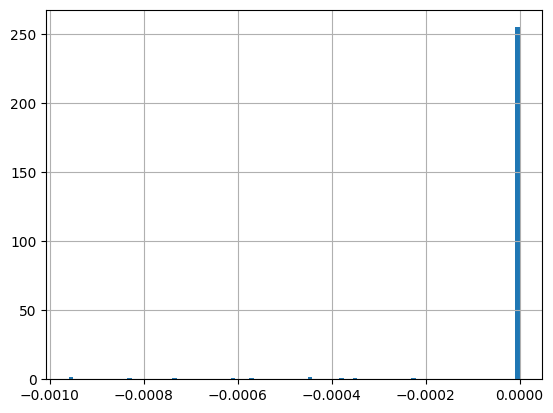

In [15]:
# take difference between TrialStart and DotOnsetTime_harp
test = trials_df['TrialStart'] - trials_df['DotOnsetTime']

# Get histogram of differences between DotOnsetTime_harp and DotOnsetTime
fig, ax = plt.subplots()
test.hist(bins=100, ax=ax)

Trial start time inferred from TTL pulses has some jitter relative to TrialStart (or DotOnset) in experimental-data.csv:

0


Text(0.5, 1.0, 'Histogram of differences between DotOnsetTime_harp_ttl and TrialStart')

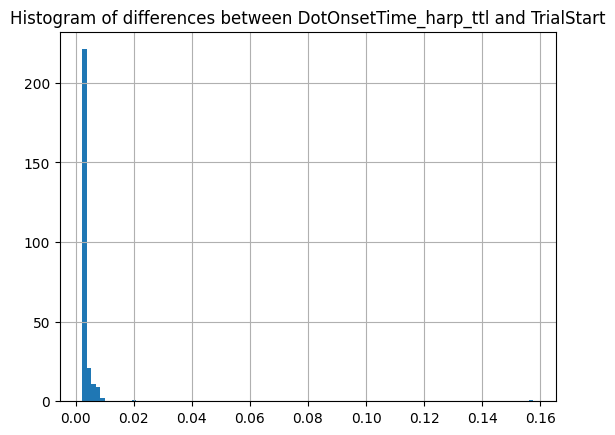

In [17]:
# take difference between TrialStart and DotOnsetTime_harp_ttl
trials_df['DotOnsetTime_harp_diff'] = trials_df['DotOnsetTime_harp_ttl'] - trials_df['TrialStart']
print(sum(trials_df['DotOnsetTime_harp_diff'] < 0))
# Get histogram of differences between DotOnsetTime_harp_ttl and DotOnsetTime
fig, ax = plt.subplots()
trials_df['DotOnsetTime_harp_diff'].hist(bins=100, ax=ax)
ax.set_title('Histogram of differences between DotOnsetTime_harp_ttl and TrialStart')

Timestamp of nosepoke for port choice is identical in both experimental-data.csv and harp binary files:

<Axes: >

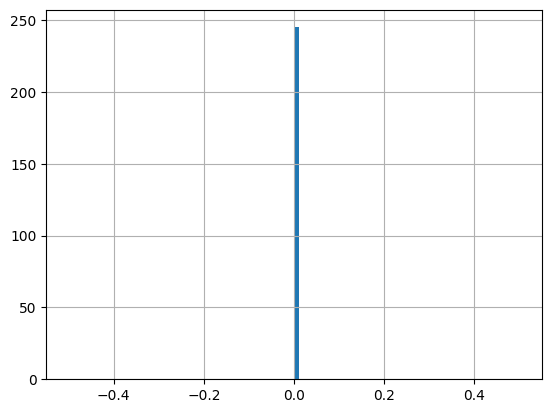

In [18]:
# take difference between TrialStart and DotOnsetTime_harp
trials_df['choiceTimestamp_diff'] = trials_df['ChoiceTimestamp'] - trials_df['NosepokeInTime']

# Get histogram of differences between DotOnsetTime_harp and DotOnsetTime
fig, ax = plt.subplots()
trials_df['choiceTimestamp_diff'].hist(bins=100, ax=ax)

Compare sound onset time in experimental-data.csv to sound onset in harp time:

In [19]:
trials_df[
    [
        'AudioCueStart',
        'AudioCueStart_harp',
        'AudioCueEnd',
        'AudioCueEnd_harp',
        'AudioCueIdentity'
    ]
].head()


,AudioCueStart,AudioCueStart_harp,AudioCueEnd,AudioCueEnd_harp,AudioCueIdentity
0,2.323389e+06,[2323388.981728],2.323397e+06,[2323397.027072],10
1,2.323435e+06,"[2323430.79616, 2323433.580192, 2323434.782848]",2.323436e+06,"[2323431.358848, 2323433.721504, 2323436.337536]",14
2,2.323441e+06,[2323440.705536],2.323436e+06,[2323443.646848],10
3,2.323459e+06,"[2323458.05824, 2323459.119584]",2.323460e+06,"[2323458.68224, 2323460.223584]",10
4,2.323471e+06,"[2323467.759584, 2323470.503584]",2.323472e+06,"[2323469.639584, 2323471.943584]",14


AudioCueStart in experimental-data.csv matches the final instance of Audio Cue Onset from harp binaries within the trial

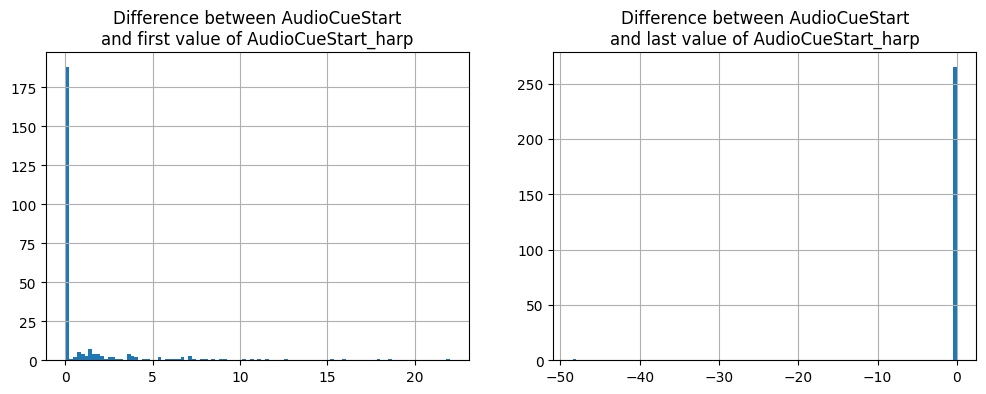

In [20]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Get difference between AudioCueStart and first value of AudioCueStart_harp
trials_df['AudioCueStart_diff'] = trials_df['AudioCueStart'] - trials_df['AudioCueStart_harp'].apply(lambda x: x[0])

# Plot histogram of differences between AudioCueStart in harp binary file versus AudioCueStart in .csv
trials_df['AudioCueStart_diff'].hist(bins=100, ax=axs[0])
axs[0].set_title('Difference between AudioCueStart\nand first value of AudioCueStart_harp')

# Get difference between AudioCueStart and last value of AudioCueStart_harp
trials_df['AudioCueStart_diff'] = trials_df['AudioCueStart'] - trials_df['AudioCueStart_harp'].apply(lambda x: x[-1])

# Plot histogram of differences between AudioCueStart in harp binary file versus AudioCueStart in .csv
trials_df['AudioCueStart_diff'].hist(bins=100, ax=axs[1])
axs[1].set_title('Difference between AudioCueStart\nand last value of AudioCueStart_harp')

# Adjust layout to prevent overlap
# plt.tight_layout()

# Display the plots
plt.show()


AudioCueEnd from experimental-data.csv deviates significantly from first or last Audio Cue End from harp binaries in many trials

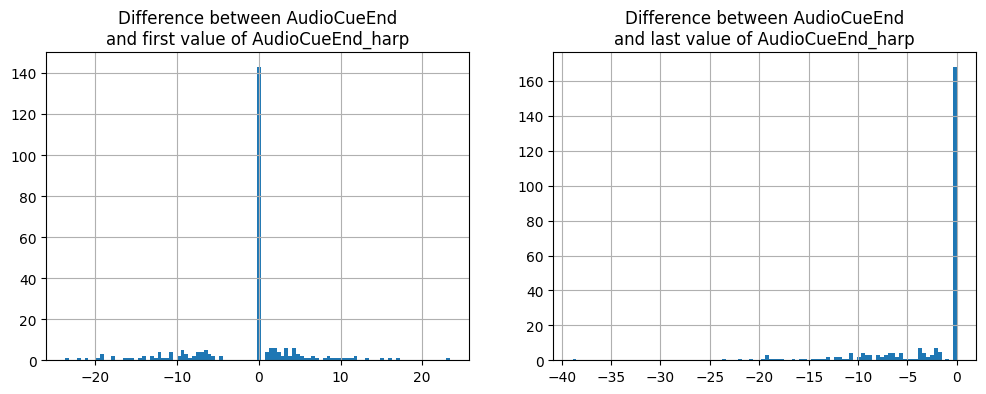

In [21]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Get difference between AudioCueEnd and first value of AudioCueEnd_harp
trials_df['AudioCueEnd_diff'] = trials_df['AudioCueEnd'] - trials_df['AudioCueEnd_harp'].apply(lambda x: x[0])

# Plot histogram of differences between AudioCueEnd in harp binary file versus AudioCueEnd in .csv
trials_df['AudioCueEnd_diff'].hist(bins=100, ax=axs[0])
axs[0].set_title('Difference between AudioCueEnd\nand first value of AudioCueEnd_harp')

# Get difference between AudioCueEnd and last value of AudioCueEnd_harp
trials_df['AudioCueEnd_diff'] = trials_df['AudioCueEnd'] - trials_df['AudioCueEnd_harp'].apply(lambda x: x[-1])

# Plot histogram of differences between AudioCueEnd in harp binary file versus AudioCueEnd in .csv
trials_df['AudioCueEnd_diff'].hist(bins=100, ax=axs[1])
axs[1].set_title('Difference between AudioCueEnd\nand last value of AudioCueEnd_harp')

# Adjust layout to prevent overlap
# plt.tight_layout()

# Display the plots
plt.show()

Using TrialStart from experimental-data.csv as the trial start introduces anomalies in the Audio Cue Start/End times within the trial:

In [28]:
def parse_trial_sounds(trial_start_times, bin_sound_path, OFF_index=18):
    # Read the harp sound card stream, for the timestamps and audio ID
    all_sounds = hu.get_all_sounds(bin_sound_path)

    # Create lists to store the poke IDs and timestamps for all trials
    ON_S, OFF_S, ID_S = [], [], []

    # Iterate through trial start times and extract data from harp stream
    for i, start_time in enumerate(trial_start_times):
        if i < len(trial_start_times) - 1:
            end_time = trial_start_times[i + 1]
        else:
            end_time = start_time + 100  # 100 seconds after the last trial start time

        # Extract events that occur within the time range of this trial
        trial_events = all_sounds[(all_sounds.Time >= start_time) & (all_sounds.Time <= end_time)]

        # Create trial lists for sounds this trial
        ON, OFF, ID = [], [], []
        for _, sound in trial_events.iterrows():
            event_time = sound.Time
            sound = sound[['PlaySoundOrFrequency']]
            sound = int(sound.iloc[0])

            # Find audio IDs from the value. Only find ID for OFFSET
            if sound != OFF_index:
                ON.append(event_time)
                ID.append(sound)
            else:
                OFF.append(event_time)

        ON_S.append(ON)
        OFF_S.append(OFF)
        ID_S.append(ID)
        
    trial_sounds_df = pd.DataFrame({'AudioCueStart_harp': ON_S, 'AudioCueEnd_harp': OFF_S, 'AudioCueIdentity_harp': ID_S})  # Create dataframe from all nosepoke events

    return trial_sounds_df

# Get data frame with sound ID and timestamp for each trial from Trial Start inferred from harp TTLs
trial_sounds_df_TrialStart_harp = parse_trial_sounds(trials_df['TrialStart_harp'], bin_sound_path)

# Get data frame with sound ID and timestamp for each trial from Trial Start taken from experimental-data.csv
trial_sounds_df_TrialStart = parse_trial_sounds(trials_df['TrialStart'], bin_sound_path)

# Check if trial_sounds_df_TrialStart_harp and trial_sounds_df_TrialStart are the same
are_identical = trial_sounds_df_TrialStart_harp.equals(trial_sounds_df_TrialStart)
print(are_identical)

# Pinpoint specific trials where the sound dataframes differ
diff = trial_sounds_df_TrialStart_harp != trial_sounds_df_TrialStart
diff_idx = diff.any(axis=1)
print(trial_sounds_df_TrialStart_harp[diff_idx])
print(trial_sounds_df_TrialStart[diff_idx])

KeyError: 1

Check that TrialStart from experimental-data.csv always precedes TrialStart_harp:

In [ ]:
print(sum(trials_df['TrialStart_harp'] < trials_df['TrialStart']))